In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [4]:


hd_pct = 0.001

strategy_name = '绿盘低吸'
days = 3
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 2,
        "top_cx": 1,
        "only_fx": True,
        "enbale_industry": False,
        "empty_priority": False
      },
      
        ]

filter_count = 0
filter_amount = 12000000
gap = 0
rank_filter = False
sell_use_open = True

In [5]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        print(f"{stock_code}-{datekey}")
        real_amount = 0

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        print(f"{stock_code}-{datekey}")
        last_price_real = -1

    return last_price_real

In [6]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\new_strategy_eval\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [7]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [8]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,898,2024-09-02,低吸,绿盘低吸,603176.XSHG,汇通集团,1,"000008.BKDL,000010.BKDL,000011.BKDL,000007.BKD...","885514.DDBK,885991.DDBK,885705.DDBK,885690.DDB...",980338.ZHBK,...,绿盘低吸,23.23,23.38,22,16.33,-3.11,25,"{""9A0001"": {""realShortLineScore"": 23.04, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:41:21
1,899,2024-09-02,低吸,绿盘低吸,603207.XSHG,小方制药,2,,,980378.ZHBK,...,绿盘低吸,23.23,23.38,22,16.33,-3.11,25,"{""9A0001"": {""realShortLineScore"": 23.04, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:41:21
2,900,2024-09-02,低吸,绿盘低吸,000759.XSHE,中百集团,3,"000012.BKDL,000024.BKDL,000026.BKDL,000018.BKD...","885951.DDBK,886021.DDBK,885812.DDBK,885901.DDB...","980374.ZHBK,980345.ZHBK",...,绿盘低吸,23.23,23.38,22,16.33,-3.11,25,"{""9A0001"": {""realShortLineScore"": 23.04, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:41:21
3,925,2024-09-03,低吸,绿盘低吸,603350.XSHG,安乃达,1,,,980474.ZHBK,...,绿盘低吸,16.81,-6.42,13,4.23,-7.82,23,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:42:24
4,926,2024-09-03,低吸,绿盘低吸,002426.XSHE,胜利精密,2,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",...,绿盘低吸,16.81,-6.42,13,4.23,-7.82,23,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:42:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2914,2025-03-21,低吸,绿盘低吸,002789.XSHE,建艺集团,2,"000023.BKDL,000015.BKDL,000019.BKDL,000007.BKD...","885869.DDBK,885827.DDBK,885984.DDBK,883436.DDB...",980338.ZHBK,...,绿盘低吸,-52.85,-27.83,47,-37.76,-13.19,39,"{""9A0001"": {""realShortLineScore"": -1.6700001, ...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-24 08:00:18
378,2915,2025-03-21,低吸,绿盘低吸,002033.XSHE,丽江股份,3,"000012.BKDL,000038.BKDL,000023.BKDL,000010.BKD...","885869.DDBK,885338.DDBK,885694.DDBK,886086.DDB...","980336.ZHBK,980346.ZHBK,980473.ZHBK,980756.ZHBK",...,绿盘低吸,-52.85,-27.83,47,-37.76,-13.19,39,"{""9A0001"": {""realShortLineScore"": -1.6700001, ...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-24 08:00:18
379,2979,2025-03-24,低吸,绿盘低吸,601028.XSHG,玉龙股份,1,"000038.BKDL,000008.BKDL,000035.BKDL,000023.BKD...","886003.DDBK,885338.DDBK,885692.DDBK,886021.DDB...","980365.ZHBK,980374.ZHBK,980345.ZHBK,980335.ZHBK",...,绿盘低吸,-87.94,-27.03,43,-40.98,-0.33,39,"{""9C0001"": {""realShortLineScore"": -37.01, ""rea...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-03-24 08:00:45
380,2980,2025-03-24,低吸,绿盘低吸,001318.XSHE,阳光乳业,2,"000021.BKDL,000010.BKDL,000006.BKDL","885420.DDBK,885502.DDBK,885462.DDBK,885784.DDB...",,...,绿盘低吸,-87.94,-27.03,43,-40.98,-0.33,39,"{""9C0001"": {""realShortLineScore"": -37.01, ""rea...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-03-24 08:00:45


In [9]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [10]:
combined_df = combined_df.reset_index(drop=True)

In [11]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']

In [12]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
372,2578,2025-03-19,低吸,绿盘低吸,002105.XSHE,信隆健康,2,"000012.BKDL,000021.BKDL,000026.BKDL,000014.BKD...","885785.DDBK,885840.DDBK,885420.DDBK,885522.DDB...",980372.ZHBK,3,17,15,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,150.82,233.14,0.0,-5.03,11.15,10.65,-1.0,10.63,10.79,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,4.62,-92.34,27,-22.89,-25.76,29,2025-03-20 08:00:28
373,2738,2025-03-20,低吸,绿盘低吸,002559.XSHE,亚威股份,1,"000023.BKDL,000018.BKDL,000035.BKDL,000006.BKD...","885743.DDBK,886042.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,100,100,100,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,242.76,252.05,0.0,-1.59,11.74,13.12,-1.0,12.99,12.10,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-80.25,-5.45,50,-44.85,4.44,37,2025-03-21 08:00:19
374,2739,2025-03-20,低吸,绿盘低吸,000905.XSHE,厦门港务,2,"000038.BKDL,000026.BKDL,000018.BKDL,000010.BKD...","885338.DDBK,883436.DDBK,886021.DDBK,885694.DDB...",980339.ZHBK,100,100,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,213.69,324.80,0.0,-2.33,8.40,8.05,-1.0,8.13,7.95,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-80.25,-5.45,50,-44.85,4.44,37,2025-03-21 08:00:19
375,2740,2025-03-20,低吸,绿盘低吸,002144.XSHE,宏达高科,3,"000015.BKDL,000027.BKDL,000004.BKDL,000009.BKD...","885924.DDBK,885832.DDBK,885431.DDBK,885539.DDB...",,100,100,-1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,151.72,364.91,0.0,-0.08,11.85,12.02,-1.0,11.99,11.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-80.25,-5.45,50,-44.85,4.44,37,2025-03-21 08:00:19
376,2913,2025-03-21,低吸,绿盘低吸,002927.XSHE,泰永长征,1,"000003.BKDL,000035.BKDL,000027.BKDL,000004.BKD...","885929.DDBK,885461.DDBK,886001.DDBK,885311.DDB...",980474.ZHBK,2,2,35,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,626.98,502.73,0.0,-6.36,17.67,16.98,-1.0,16.10,15.28,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-52.85,-27.83,47,-37.76,-13.19,39,2025-03-24 08:00:18
377,2914,2025-03-21,低吸,绿盘低吸,002789.XSHE,建艺集团,2,"000023.BKDL,000015.BKDL,000019.BKDL,000007.BKD...","885869.DDBK,885827.DDBK,885984.DDBK,883436.DDB...",980338.ZHBK,3,7,36,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.0,297.66,354.35,0.0,-6.98,8.79,10.40,-1.0,10.36,9.36,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-52.85,-27.83,47,-37.76,-13.19,39,2025-03-24 08:00:18
378,2915,2025-03-21,低吸,绿盘低吸,002033.XSHE,丽江股份,3,"000012.BKDL,000038.BKDL,000023.BKDL,000010.BKD...","885869.DDBK,885338.DDBK,885694.DDBK,886086.DDB...","980336.ZHBK,980346.ZHBK,980473.ZHBK,980756.ZHBK",1,3,39,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,118.23,314.36,0.0,-2.18,9.43,9.62,-1.0,9.75,9.78,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-52.85,-27.83,47,-37.76,-13.19,39,2025-03-24 08:00:18
379,2979,2025-03-24,低吸,绿盘低吸,601028.XSHG,玉龙股份,1,"000038.BKDL,000008.BKDL,000035.BKDL,000023.BKD...","886003.DDBK,885338.DDBK,885692.DDBK,886021.DDB...","980365.ZHBK,980374.ZHBK,980345.ZHBK,980335.ZHBK",2,7,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,715.32,794.63,0.0,-2.53,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-87.94,-27.03,43,-40.98,-0.33,39,2025-03-24 08:00:45
380,2980,2025-03-24,低吸,绿盘低吸,001318.XSHE,阳光乳业,2,"000021.BKDL,000010.BKDL,000006.BKDL","885420.DDBK,885502.DDBK,885462.DDBK,885784.DDB...",,8,75,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,668.12,342.97,0.0,-7.02,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0

In [13]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 603176.SH 日期 2024-09-02 过滤原因： first_tick_amount 2521330.0
过滤股票 603207.SH 日期 2024-09-02 过滤原因： first_tick_amount 7050926.0
过滤股票 000759.SZ 日期 2024-09-02 过滤原因： first_tick_amount 7107660.0
过滤股票 603350.SH 日期 2024-09-03 过滤原因： first_tick_amount 6813352.0
过滤股票 600543.SH 日期 2024-09-03 过滤原因： first_tick_amount 5643840.0
过滤股票 001373.SZ 日期 2024-09-05 过滤原因： first_tick_amount 3782880.0
过滤股票 603276.SH 日期 2024-09-06 过滤原因： first_tick_amount 2920835.0
过滤股票 603978.SH 日期 2024-09-06 过滤原因： first_tick_amount 7810800.0
过滤股票 600156.SH 日期 2024-09-11 过滤原因： first_tick_amount 9251996.0
过滤股票 000020.SZ 日期 2024-09-12 过滤原因： first_tick_amount 11838456.0
过滤股票 600193.SH 日期 2024-09-13 过滤原因： first_tick_amount 8081050.0
过滤股票 603191.SH 日期 2024-09-13 过滤原因： first_tick_amount 7716684.0
过滤股票 603188.SH 日期 2024-09-18 过滤原因： first_tick_amount 8768420.0
过滤股票 603607.SH 日期 2024-09-20 过滤原因： first_tick_amount 11482038.0
过滤股票 603536.SH 日期 2024-09-23 过滤原因： first_tick_amount 6301386.0
过滤股票 603091.SH 日期 2024-09-25 过滤原因： first_tick_amount 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,948,低吸,绿盘低吸,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,1,24,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,601.86,555.57,0.0,-8.60,4.36,4.45,-1.0,4.39,4.90,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-4.85,-21.66,31,-2.85,-19.74,29,2025-02-15 17:43:25,29439810.0,0.006881,0.005881,0.123853,0.122853
2024-09-05,999,低吸,绿盘低吸,002383.XSHE,合众思壮,2,"000008.BKDL,000023.BKDL,000019.BKDL,000016.BKD...","886021.DDBK,885574.DDBK,885932.DDBK,885564.DDB...","980363.ZHBK,980366.ZHBK",1,1,15,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,164.55,381.09,0.0,0.00,5.95,6.55,-1.0,6.99,6.68,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-31.47,-26.62,36,-17.14,-6.65,32,2025-02-15 17:44:29,17812515.0,0.174790,0.173790,0.122689,0.121689
2024-09-09,1094,低吸,绿盘低吸,600829.XSHG,人民同泰,3,"000006.BKDL,000004.BKDL,000009.BKDL","885490.DDBK,885502.DDBK,885879.DDBK,885539.DDB...","980345.ZHBK,980378.ZHBK",1,1,3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,107.35,307.85,0.0,-2.77,6.31,5.89,-1.0,5.87,5.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-20.11,-12.17,42,-17.36,-15.20,32,2025-02-15 17:46:40,14354304.0,-0.069731,-0.070731,-0.118859,-0.119859
2024-09-11,1188,低吸,绿盘低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",1,1,100,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,248.36,360.03,0.0,-9.93,6.62,6.62,-1.0,6.35,6.24,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-10.37,2.90,39,-26.82,-7.66,30,2025-02-15 17:48:48,39347466.0,-0.040785,-0.041785,-0.057402,-0.058402
2024-09-24,1457,低吸,绿盘低吸,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000015.BKDL,000017.BKDL","885694.DDBK,886021.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",1,1,31,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,372.85,381.11,0.0,-7.18,9.56,11.33,-1.0,12.46,11.40,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,58.14,17.71,25,15.74,-7.85,22,2025-02-15 17:56:12,26714464.0,0.303347,0.302347,0.192469,0.191469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,1441,低吸,绿盘低吸,000700.XSHE,模塑科技,3,"000038.BKDL,000014.BKDL,000015.BKDL,000027.BKD...","885984.DDBK,885785.DDBK,885490.DDBK,885694.DDB...",980372.ZHBK,2,1,28,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,187.84,373.56,0.0,-1.13,7.86,8.05,-1.0,7.89,8.35,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,56.81,12.81,20,-10.15,-11.42,31,2025-03-11 08:00:34,40818552.0,0.003817,0.002817,0.062341,0.061341
2025-03-11,1619,低吸,绿盘低吸,000409.XSHE,云鼎科技,2,"000008.BKDL,000023.BKDL,000016.BKDL,000034.BKD...","885459.DDBK,885398.DDBK,886062.DDBK,885311.DDB...","980753.ZHBK,980366.ZHBK,980352.ZHBK",1,1,11,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,234.29,252.19,0.0,-2.83,13.71,15.16,-1.0,16.02,15.41,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-71.98,-105.14,50,-36.67,-19.21,34,2025-03

In [14]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.42' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [15]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-04,4.36,4.90,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-05,5.95,6.68,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-09,6.31,5.56,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-11,6.62,6.24,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-24,9.56,11.40,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,7.86,8.35,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-03-11,13.71,15.41,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2025-03-12,23.00,23.30,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [16]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [17]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,948,低吸,绿盘低吸,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,1,24,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,601.86,555.57,0.0,-8.60,4.36,4.45,-1.0,4.39,4.90,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-4.85,-21.66,31,-2.85,-19.74,29,2025-02-15 17:43:25,29439810.0,0.006881,0.005881,0.123853,0.122853,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.42
2024-09-05,999,低吸,绿盘低吸,002383.XSHE,合众思壮,2,"000008.BKDL,000023.BKDL,000019.BKDL,000016.BKD...","886021.DDBK,885574.DDBK,885932.DDBK,885564.DDB...","980363.ZHBK,980366.ZHBK",1,1,15,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,164.55,381.09,0.0,0.00,5.95,6.55,-1.0,6.99,6.68,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-31.47,-26.62,36,-17.14,-6.65,32,2025-02-15 17:44:29,17812515.0,0.174790,0.173790,0.122689,0.121689,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.00
2024-09-09,1094,低吸,绿盘低吸,600829.XSHG,人民同泰,3,"000006.BKDL,000004.BKDL,000009.BKDL","885490.DDBK,885502.DDBK,885879.DDBK,885539.DDB...","980345.ZHBK,980378.ZHBK",1,1,3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,107.35,307.85,0.0,-2.77,6.31,5.89,-1.0,5.87,5.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-20.11,-12.17,42,-17.36,-15.20,32,2025-02-15 17:46:40,14354304.0,-0.069731,-0.070731,-0.118859,-0.119859,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.35
2024-09-11,1188,低吸,绿盘低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",1,1,100,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,248.36,360.03,0.0,-9.93,6.62,6.62,-1.0,6.35,6.24,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-10.37,2.90,39,-26.82,-7.66,30,2025-02-15 17:48:48,39347466.0,-0.040785,-0.041785,-0.057402,-0.058402,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.63
2024-09-24,1457,低吸,绿盘低吸,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000015.BKDL,000017.BKDL","885694.DDBK,886021.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",1,1,31,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,372.85,381.11,0.0,-7.18,9.56,11.33,-1.0,12.46,11.40,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,58.14,17.71,25,15.74,-7.85,22,2025-02-15 17:56:12,26714464.0,0.303347,0.302347,0.192469,0.191469,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,1277,低吸,绿盘低吸,603118.XSHG,共进股份,3,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885840.DDBK,885843.DDBK,885459.DDBK,886009.DDB...",980376.ZHBK,1,1,29,0,0,0,0,0,0,1

In [18]:
def get_stock_open_close_price(auction_code, date, next_date):
    if '-' in date or '-' in next_date:
        n_date = date.replace('-', '')
        n_next_date = next_date.replace('-', '')
    xtdata.download_history_data(auction_code, period='1d', start_time=n_date, end_time=n_next_date, incrementally = None)
    x1dpdata = xtdata.get_local_data(field_list=[], stock_list=[auction_code], period='1d', start_time=n_date, end_time=n_next_date, count=-1,
               dividend_type='none', fill_data=True)
    df = x1dpdata[auction_code]
    length = len(df)
    if length != 1:
        return -1, -1, -1, -1
    x_data = df.loc[n_date: n_next_date]['open'].astype(float)
    x_data_close = df.loc[n_date: n_next_date]['close'].astype(float)
    start_price = x_data[n_date]
    end_price = x_data[n_next_date]
    close_price = x_data_close[n_date]
    n_close_price = x_data_close[n_next_date]
    return start_price, close_price, end_price, n_close_price

In [19]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from date_utils import get_trade_dates_by_end, get_current_date
last_100_trade_days = get_trade_dates_by_end(get_current_date(), 200)


In [20]:
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    date_key_index = last_100_trade_days.index(date_key)
    after_trade_days = last_100_trade_days[date_key_index+1:date_key_index+11]
    for idx, day in enumerate(after_trade_days):
        open_price, close_price, _, _ = get_stock_open_close_price(stock_code, day, day)
        if open_price > 0:
            combined_df.loc[date_key, f'low_{idx+1}'] = open_price
            combined_df.loc[date_key, f'close_{idx+1}'] = close_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\3217630104.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.39' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'low_{idx+1}'] = open_price
C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\3217630104.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'close_{idx+1}'] = close_price
C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\3217630104.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.89' has dtype incompatible with int64, please explicitly cast to a compatible dtype

In [21]:
combined_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,948,低吸,绿盘低吸,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,1,24,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,601.86,555.57,0.0,-8.60,4.36,4.45,-1.0,4.39,4.90,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-4.85,-21.66,31,-2.85,-19.74,29,2025-02-15 17:43:25,29439810.0,0.006881,0.005881,0.123853,0.122853,4.90,4.39,4.52,4.89,4.33,4.41,4.46,4.24,4.55,4.35,4.48,4.46,4.24,4.45,4.12,4.26,4.30,4.18,4.40,4.29,4.42
2024-09-05,999,低吸,绿盘低吸,002383.XSHE,合众思壮,2,"000008.BKDL,000023.BKDL,000019.BKDL,000016.BKD...","886021.DDBK,885574.DDBK,885932.DDBK,885564.DDB...","980363.ZHBK,980366.ZHBK",1,1,15,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,164.55,381.09,0.0,0.00,5.95,6.55,-1.0,6.99,6.68,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-31.47,-26.62,36,-17.14,-6.65,32,2025-02-15 17:44:29,17812515.0,0.174790,0.173790,0.122689,0.121689,6.68,6.99,6.06,6.12,6.02,6.06,5.88,6.02,5.94,5.85,5.70,5.91,5.66,5.70,5.90,5.73,6.06,5.98,6.14,6.03,6.00
2024-09-09,1094,低吸,绿盘低吸,600829.XSHG,人民同泰,3,"000006.BKDL,000004.BKDL,000009.BKDL","885490.DDBK,885502.DDBK,885879.DDBK,885539.DDB...","980345.ZHBK,980378.ZHBK",1,1,3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,107.35,307.85,0.0,-2.77,6.31,5.89,-1.0,5.87,5.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-20.11,-12.17,42,-17.36,-15.20,32,2025-02-15 17:46:40,14354304.0,-0.069731,-0.070731,-0.118859,-0.119859,5.56,5.87,5.38,5.48,5.32,5.37,5.19,5.31,5.19,5.19,5.31,5.19,5.23,5.27,5.21,5.23,5.38,5.23,5.44,5.42,6.35
2024-09-11,1188,低吸,绿盘低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",1,1,100,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,248.36,360.03,0.0,-9.93,6.62,6.62,-1.0,6.35,6.24,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-10.37,2.90,39,-26.82,-7.66,30,2025-02-15 17:48:48,39347466.0,-0.040785,-0.041785,-0.057402,-0.058402,6.24,6.35,5.98,6.25,5.91,5.97,6.10,5.93,6.12,6.13,6.18,6.18,6.27,6.15,6.28,6.26,6.42,6.26,6.76,6.62,6.63
2024-09-24,1457,低吸,绿盘低吸,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000015.BKDL,000017.BKDL","885694.DDBK,886021.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",1,1,31,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,372.85,381.11,0.0,-7.18,9.56,11.33,-1.0,12.46,11.40,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,58.14,17.71,25,15.74,-7.85,22,2025-02-15 17:56:12,26714464.0,0.303347,0.302347,0.192469,0.191469,11.40,12.46,11.69,10.55,12.06,11.60,13.27,12.52,14.60,14.60,13.14,13.89,11.83,12.61,11.10,11.00,11.29,11.35,11.24,11.01,9.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [76]:
def caculate_returns(returns_df, row, _print = False, save_to_file=False, file_path='results.txt', extra_info=None):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    cumulative_returns_add = returns_df[row].cumsum()
    cumulative_max_add = cumulative_returns_add.cummax()
    drawdown_add = cumulative_returns_add - cumulative_max_add
    max_drawdown_add = drawdown_add.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    if 'sell_day' in returns_df.columns:
        mean_sell_day = returns_df['sell_day'].mean()
    else:
        mean_sell_day = -1
    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算加和的收益
    sum_return = returns_df[row].sum()

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['加和的最大回撤'] =  max_drawdown_add
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['加和的收益'] = sum_return
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    r['平均卖天数'] = mean_sell_day
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"加和的最大回撤: {max_drawdown_add:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"加和的收益: {sum_return:.2%}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")
    
    if save_to_file:
        with open(file_path, 'a', encoding='utf-8') as f:
            f.write("---------------------------------------------------------------\n")
            f.write(f"策略: {row} , extrainfo:{extra_info}\n")
            for key, value in r.items():
                if isinstance(value, float):
                    if key in ['最大回撤', '加和的最大回撤', '总收益率', '年化收益率', '波动率', '总盈亏', '成功次数', '失败次数', '加和的收益', '平均盈利', '平均亏损', '最大盈利', '最大亏损', '凯利公式最佳仓位', '平均卖天数']:
                        f.write(f"{key}: {value:.2%}\n")
                    elif key in ['夏普比率', '盈亏比', '胜率']:
                        f.write(f"{key}: {value:.2f}\n")
                else:
                    f.write(f"{key}: {value}\n")
            f.write("---------------------------------------------------------------")

    return r

In [23]:
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,948,低吸,绿盘低吸,002514.XSHE,宝馨科技,1,"000038.BKDL,000035.BKDL,000023.BKDL,000018.BKD...","885878.DDBK,885739.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,1,24,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,601.86,555.57,0.0,-8.60,4.36,4.45,-1.0,4.39,4.90,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-4.85,-21.66,31,-2.85,-19.74,29,2025-02-15 17:43:25,29439810.0,0.006881,0.005881,0.123853,0.122853,4.90,4.39,4.52,4.89,4.33,4.41,4.46,4.24,4.55,4.35,4.48,4.46,4.24,4.45,4.12,4.26,4.30,4.18,4.40,4.29,4.42
2024-09-05,999,低吸,绿盘低吸,002383.XSHE,合众思壮,2,"000008.BKDL,000023.BKDL,000019.BKDL,000016.BKD...","886021.DDBK,885574.DDBK,885932.DDBK,885564.DDB...","980363.ZHBK,980366.ZHBK",1,1,15,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,164.55,381.09,0.0,0.00,5.95,6.55,-1.0,6.99,6.68,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-31.47,-26.62,36,-17.14,-6.65,32,2025-02-15 17:44:29,17812515.0,0.174790,0.173790,0.122689,0.121689,6.68,6.99,6.06,6.12,6.02,6.06,5.88,6.02,5.94,5.85,5.70,5.91,5.66,5.70,5.90,5.73,6.06,5.98,6.14,6.03,6.00
2024-09-09,1094,低吸,绿盘低吸,600829.XSHG,人民同泰,3,"000006.BKDL,000004.BKDL,000009.BKDL","885490.DDBK,885502.DDBK,885879.DDBK,885539.DDB...","980345.ZHBK,980378.ZHBK",1,1,3,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,107.35,307.85,0.0,-2.77,6.31,5.89,-1.0,5.87,5.56,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-20.11,-12.17,42,-17.36,-15.20,32,2025-02-15 17:46:40,14354304.0,-0.069731,-0.070731,-0.118859,-0.119859,5.56,5.87,5.38,5.48,5.32,5.37,5.19,5.31,5.19,5.19,5.31,5.19,5.23,5.27,5.21,5.23,5.38,5.23,5.44,5.42,6.35
2024-09-11,1188,低吸,绿盘低吸,000058.XSHE,深赛格,2,"000012.BKDL,000038.BKDL,000023.BKDL,000035.BKD...","886021.DDBK,885574.DDBK,885729.DDBK,885697.DDB...","980374.ZHBK,980353.ZHBK",1,1,100,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,248.36,360.03,0.0,-9.93,6.62,6.62,-1.0,6.35,6.24,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-10.37,2.90,39,-26.82,-7.66,30,2025-02-15 17:48:48,39347466.0,-0.040785,-0.041785,-0.057402,-0.058402,6.24,6.35,5.98,6.25,5.91,5.97,6.10,5.93,6.12,6.13,6.18,6.18,6.27,6.15,6.28,6.26,6.42,6.26,6.76,6.62,6.63
2024-09-24,1457,低吸,绿盘低吸,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000015.BKDL,000017.BKDL","885694.DDBK,886021.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",1,1,31,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,372.85,381.11,0.0,-7.18,9.56,11.33,-1.0,12.46,11.40,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,58.14,17.71,25,15.74,-7.85,22,2025-02-15 17:56:12,26714464.0,0.303347,0.302347,0.192469,0.191469,11.40,12.46,11.69,10.55,12.06,11.60,13.27,12.52,14.60,14.60,13.14,13.89,11.83,12.61,11.10,11.00,11.29,11.35,11.24,11.01,9.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
import re

sell_use_open = True
sell_days = [2,3,4,5,6,7]
zhisun_lines  = [-0.01, -0.02,-0.03,-0.035,-0.04,-0.045,-0.05,-0.055,-0.06,-0.065,-0.07,-0.075,-0.08,-0.09,-0.10,-0.11,-0.12,-0.13,-0.14,-0.15]
zhiying_lines = [0, 0.01,0.015,0.02,0.025, 0.03,0.035, 0.04,0.045, 0.05,0.055, 0.065,0.08, 0.1]


max_rate = -1
max_rate_info = ""

max_rate_df = pd.DataFrame()

max_return = -1
max_return_info = ""
max_return_df = pd.DataFrame()

max_ykb = -1
max_ykb_info = ""
max_ykb_df = pd.DataFrame()

min_hc = -100
min_hc_info = ""
min_hc_df = pd.DataFrame()

for sell_day in sell_days:
    for zhisun_line in zhisun_lines:
        for zhiying_line in zhiying_lines:
            extra_info = f'zhisun_{sell_day}_{zhisun_line}_{zhiying_line}'
            ndf = ddwndx.copy()
            ndf = ndf[ndf['real_open'] > 0]
            for date_key, row in ndf.tail(20).iterrows():
                real_open = row['real_open']
                ndf.at[date_key, 'sy'] = -100
                ndf.at[date_key,'sell_day'] = -1
                for i in range(1, sell_day+1):
                    if sell_use_open:
                        cs = row[f'low_{i}']
                        if cs < 0:
                            continue
                        sy = cs / real_open - 1
                        if sy < zhisun_line:
                            ndf.at[date_key, 'sy'] = sy
                            ndf.at[date_key,'sell_day'] = i
                            break
                        if sy > zhiying_line:
                            ndf.at[date_key,'sy'] = sy
                            ndf.at[date_key,'sell_day'] = i
                            break

                    cs = row[f'close_{i}']
                    if cs < 0:
                        continue
                    if i == sell_day:
                        cs = row[f'close_{i}']
                        ndf.at[date_key,'sy'] = cs / real_open - 1
                        ndf.at[date_key,'sell_day'] = i
                        break
                    sy = cs / real_open - 1
                    if sy < zhisun_line:
                        ndf.at[date_key, 'sy'] = sy
                        ndf.at[date_key,'sell_day'] = i
                        break
                    if sy > zhiying_line:
                        ndf.at[date_key,'sy'] = sy
                        ndf.at[date_key,'sell_day'] = i
                        break
            ndf = ndf[ndf['sy'] > -99]
            if len(ndf) == 0:
                continue
            r= caculate_returns(ndf,'sy',_print = False, save_to_file=True, file_path='.\\results.txt', extra_info=extra_info)
            if r['胜率'] > max_rate:
                max_rate_info = extra_info
                max_rate = max(max_rate, r['胜率'])
                max_rate_df = ndf.copy()
            if r['加和的收益'] > max_return:
                max_return_info = extra_info
                max_return = max(max_return, r['加和的收益'])
                max_return_df = ndf.copy()

            if r['夏普比率'] > max_ykb:
                max_ykb_info = extra_info
                max_ykb = max(max_ykb, r['夏普比率'])
                max_ykb_df = ndf.copy()

            if r['加和的最大回撤'] > min_hc:
                min_hc_info = extra_info
                min_hc = max(min_hc, r['加和的最大回撤'])
                min_hc_df = ndf.copy()

print(max_rate_info)
print(max_rate)


print(max_return_info)
print(max_return)


print(max_ykb_info)
print(max_ykb)

print(min_hc_info)
print(min_hc)

zhisun_2_-0.06_0
0.75
zhisun_3_-0.01_0.04
0.6063079974595412
zhisun_3_-0.01_0.04
0.40314183603074666
zhisun_2_-0.06_0.04
-0.14845024469820556


In [58]:

total_sys = []

bc_date = []

for i in range (1, 110):
    first = 100000
    total_add = 0
    all_sys= []
    all_firsts = []
    total_sy = 0
    first_date_key = ''
    for date_key, row in max_ykb_df.tail(i).iterrows():
        if not first_date_key:
            first_date_key = date_key
        sy = row['sy']
        profit = first * sy
        total_sy = total_sy + profit
        first = first + profit
        all_sys.append(first)
        if sy > 0:
            first = first + 2000
            total_add = total_add + 2000
        if sy < 0:
            first = first - 2000
            total_add = total_add - 2000
            if first < 0:
                first = 0
                print(f'爆仓 {date_key}')
                bc_date.append(date_key)
                break
        all_firsts.append(profit)
    print(f'第{i}次，从日期{first_date_key}开始 总收益{total_sy}')
    total_sys.append(total_sy)


第1次，从日期2025-03-17开始 总收益7516.778523489931
第2次，从日期2025-03-12开始 总收益3252.516345715491
第3次，从日期2025-03-11开始 总收益20303.89063190102
第4次，从日期2025-03-10开始 总收益27247.7317854522
第5次，从日期2025-03-07开始 总收益22710.23424538451
第6次，从日期2025-03-05开始 总收益32241.43629128405
第7次，从日期2025-03-03开始 总收益24130.04670159956
第8次，从日期2025-02-28开始 总收益5153.863812175419
第9次，从日期2025-02-27开始 总收益12272.124892463256
第10次，从日期2025-02-26开始 总收益18353.656637107604
第11次，从日期2025-02-25开始 总收益16725.00541260661
第12次，从日期2025-02-19开始 总收益22987.62095081644
第13次，从日期2025-02-18开始 总收益18179.172801799337
第14次，从日期2025-02-17开始 总收益28351.796075698723
第15次，从日期2025-02-14开始 总收益41744.911565669216
第16次，从日期2025-02-12开始 总收益58907.00157353951
第17次，从日期2025-02-10开始 总收益54307.741145259104
第18次，从日期2025-02-06开始 总收益61636.22269588227
第19次，从日期2025-01-27开始 总收益54443.57708110666
第20次，从日期2025-01-20开始 总收益73117.42272821568
第21次，从日期2025-01-20开始 总收益73117.42272821568
第22次，从日期2025-01-20开始 总收益73117.42272821568
第23次，从日期2025-01-20开始 总收益73117.42272821568
第24次，从日期2025-01-20开始 总收益73117.42272821

In [59]:
total_sys

[7516.778523489931,
 3252.516345715491,
 20303.89063190102,
 27247.7317854522,
 22710.23424538451,
 32241.43629128405,
 24130.04670159956,
 5153.863812175419,
 12272.124892463256,
 18353.656637107604,
 16725.00541260661,
 22987.62095081644,
 18179.172801799337,
 28351.796075698723,
 41744.911565669216,
 58907.00157353951,
 54307.741145259104,
 61636.22269588227,
 54443.57708110666,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821

In [60]:
bc_date

[]

In [61]:
max_ykb_df

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_1return,cumulative_1returns,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-20,876,低吸,绿盘低吸,002757.XSHE,南兴股份,2,"000003.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885459.DDBK,885930.DDBK,885957.DDBK,885517.DDB...",980365.ZHBK,1,1,11,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,436.41,620.69,0.0,-9.61,13.74,14.23,-1.0,14.20,13.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-24.74,-23.01,48,-83.97,-7.18,56,2025-02-15 19:34:34,30654283.0,0.033479,0.032479,0.005095,0.004095,13.81,14.20,14.01,13.84,15.41,14.25,16.95,16.90,17.49,18.65,17.54,17.43,17.29,16.72,18.15,17.09,18.22,17.72,17.65,17.79,13.84,-0.003168,0.477260,0.113439,3.0
2025-01-27,1235,低吸,绿盘低吸,002730.XSHE,电光科技,1,"000003.BKDL,000023.BKDL,000035.BKDL,000006.BKD...","885517.DDBK,885729.DDBK,885700.DDBK,885619.DDB...",980365.ZHBK,2,1,27,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0.0,1673.81,1625.53,0.0,-7.18,23.01,23.05,-1.0,22.82,20.75,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-80.34,-0.85,63,-104.11,8.23,64,2025-02-15 19:40:38,259005162.0,-0.008257,-0.009257,-0.098218,-0.099218,20.75,22.82,21.44,19.74,22.08,21.17,22.10,22.01,22.21,21.95,21.90,21.70,22.55,21.91,20.94,21.55,20.20,20.51,19.06,20.00,23.70,-0.125473,0.417377,-0.037131,1.0
2025-02-06,2258,低吸,绿盘低吸,002394.XSHE,联发股份,2,,,,-1,-1,-1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0.0,854.48,730.51,0.0,-9.58,7.55,8.00,-1.0,8.00,7.87,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,-76.84,1.03,59,-108.77,1.24,68,2025-02-28 17:17:53,32119210.0,0.059603,0.058603,0.042384,0.041384,7.87,8.00,7.93,7.89,7.97,7.88,7.92,7.95,7.91,7.90,7.78,7.89,7.77,7.77,7.58,7.75,7.66,7.52,7.66,7.66,7.69,0.022407,0.426729,0.040312,1.0
2025-02-10,2368,低吸,绿盘低吸,605055.XSHG,迎丰股份,1,,,,-1,-1,-1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0.0,443.63,625.61,0.0,-4.58,5.42,5.49,-1.0,5.40,5.26,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,8.54,-22.10,34,-72.54,-6.67,57,2025-02-28 17:19:45,19024969.0,-0.003690,-0.004690,-0.029520,-0.030520,5.26,5.40,5.31,5.26,5.20,5.31,5.22,5.22,5.31,5.23,5.24,5.32,5.29,5.24,5.27,5.28,5.28,5.29,5.32,5.28,5.52,-0.048101,0.406203,-0.021739,1.0
2025-02-12,2508,低吸,绿盘低吸,000034.XSHE,神州数码,2,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","885459.DDBK,886048.DDBK,885757.DDBK,885957.DDB...","980345.ZHBK,980366.ZHBK",1,1,10,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,95.55,192.06,0.0,-2.68,42.53,44.92,-1.0,44.50,48.13,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,38.95,3.00,27,-51.06,-4.77,59,2025-02-28 17:21:41,131566555.0,0.046320,0.045320,0.131672,0.130672,48.13,44.50,52.94,47.08,54.22,58.23,56.70,52.80,57.20,56.92,56.03,56.00,57.06,57.00,57.85,56.00,53.70,54.70,51.30,53.92,43.16,0.114153,0.452572,0.115153,1.0
2025-02-14,2591,低吸,绿盘低吸,002929.XSHE,润建股份,1,"000012.BKDL,000026.BKDL,000018.BKDL,000019.BKD...","885517.DDBK,885461.DDBK,886062.DDBK,885564.DDB...","980753.ZHBK,980376.ZHBK",1,1,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,206.01,227.51,0.0,-3.57,48.41,55.22,-1.0,53.00,51.65,-1.0,-

In [62]:
first = 20000
add_delta = 1000
m_delta = 3000
min_cw = 1000

firsts = [20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

add_deltas = [1000, 2000, 3000]

m_deltas = [1000, 2000, 3000, 4000, 5000, 6000]

min_cws = [1000, 2000, 3000, 4000, 5000, 6000, 7000]


max_total_profit = -1

max_total_params = {}


max_total_profitt = -1

max_total_paramst = {}

for cfirst in firsts:
    for cadd_delta in add_deltas:
        for cm_delta in m_deltas:
            for cmin_cw in min_cws:
                first = cfirst
                add_delta = cadd_delta
                m_delta = cm_delta
                min_cw = cmin_cw
                all_sys= []
                all_firsts = []
                total_add = 0
                total_profit = 0
                for date_key, row in max_ykb_df.iterrows():
                    sy = row['sy']
                    profit = first * sy
                    total_profit = total_profit + profit
                    first = first + profit
                    all_sys.append(first)
                    if sy > 0:
                        first = first + add_delta
                        total_add = total_add + add_delta
                    if sy < 0:
                        first = first - m_delta
                        if first > 0:
                            total_add = total_add - m_delta
                        if first <= 0:
                            total_add = total_add - m_delta + min_cw - first
                            first = min_cw
                            print(f'爆仓 {date_key}')
                    all_firsts.append(first)

                print(all_sys)
                print(all_firsts)

                print(total_add)
                print(total_profit)

                cb = total_add if total_add > 0 else 0

                x = total_profit / (cfirst + cb)
                if total_profit > max_total_profitt:
                    max_total_profitt = total_profit
                    max_total_paramst = {
                        'cfirst': cfirst,
                        'first': first,
                        'add_delta': add_delta,
                        'm_delta': m_delta,
                        'min_cw': min_cw,
                        'total_profit': total_profit,
                        'total_add': total_add,
                        'all_sys': all_sys, 
                        'all_firsts': all_firsts
                    }
                if x > max_total_profit:
                    max_total_profit = x
                    max_total_params = {
                        'cfirst': cfirst,
                        'first': first,
                        'add_delta': add_delta,
                        'm_delta': m_delta,
                        'min_cw': min_cw,
                        'total_profit': total_profit,
                        'total_add': total_add,
                        'all_sys': all_sys,
                        'all_firsts': all_firsts
                    }

[22268.786127167634, 22404.797443964784, 22267.669642616158, 22761.850737341898, 24267.791380636365, 27778.32282044653, 31142.12247844931, 31013.228420669628, 31521.603121422868, 32179.165975782984, 32784.737645632275, 36014.18733798364, 31519.422170354745, 28791.907707881834, 29843.177173971904, 29871.374142233857, 30438.885617127868, 36602.53979552242, 36163.74957978661, 37806.93075625379]
[23268.786127167634, 21404.797443964784, 23267.669642616158, 21761.850737341898, 25267.791380636365, 28778.32282044653, 32142.12247844931, 30013.228420669628, 32521.603121422868, 31179.165975782984, 33784.737645632275, 37014.18733798364, 30519.422170354745, 27791.907707881834, 30843.177173971904, 28871.374142233857, 31438.885617127868, 37602.53979552242, 35163.74957978661, 38806.93075625379]
4000
14806.930756253789
[22268.786127167634, 22404.797443964784, 22267.669642616158, 22761.850737341898, 24267.791380636365, 27778.32282044653, 31142.12247844931, 31013.228420669628, 31521.603121422868, 32179.1

In [63]:
max_total_profit

0.705939701196515

In [64]:
max_total_params

{'cfirst': 100000,
 'first': 170593.9701196515,
 'add_delta': 2000,
 'm_delta': 3000,
 'min_cw': 1000,
 'total_profit': 70593.9701196515,
 'total_add': 0,
 'all_sys': [111343.93063583816,
  109135.37962488721,
  110413.91898557836,
  109970.1381380658,
  119288.06183005346,
  133338.87734894903,
  146455.36923028383,
  143241.32699390315,
  147289.43480399076,
  147717.48745140794,
  152169.71687166317,
  164343.35301040235,
  141649.64155208814,
  130801.54863404542,
  137234.34530232503,
  134847.36668064637,
  139005.74643729764,
  164165.1204887724,
  159807.12576671707,
  168593.9701196515],
 'all_firsts': [113343.93063583816,
  106135.37962488721,
  112413.91898557836,
  106970.1381380658,
  121288.06183005346,
  135338.87734894903,
  148455.36923028383,
  140241.32699390315,
  149289.43480399076,
  144717.48745140794,
  154169.71687166317,
  166343.35301040235,
  138649.64155208814,
  127801.54863404542,
  139234.34530232503,
  131847.36668064637,
  141005.74643729764,
  166165.

In [65]:
max_total_profitt

78470.07162969508

In [66]:
max_total_paramst

{'cfirst': 100000,
 'first': 206470.07162969507,
 'add_delta': 3000,
 'm_delta': 1000,
 'min_cw': 1000,
 'total_profit': 78470.07162969508,
 'total_add': 28000,
 'all_sys': [111343.93063583816,
  110098.24882319944,
  113496.22764442072,
  113963.70095649855,
  125971.80090445494,
  141786.04953196662,
  156678.51513889479,
  154070.2941193824,
  160763.14727900867,
  162038.79855899472,
  169331.49416585325,
  183703.62322248315,
  158987.42466906394,
  149044.7402538339,
  158971.64957182223,
  156868.26676460804,
  164330.81155107034,
  194813.9244947781,
  190244.9480201284,
  203470.07162969507],
 'all_firsts': [114343.93063583816,
  109098.24882319944,
  116496.22764442072,
  112963.70095649855,
  128971.80090445494,
  144786.04953196662,
  159678.51513889479,
  153070.2941193824,
  163763.14727900867,
  161038.79855899472,
  172331.49416585325,
  186703.62322248315,
  157987.42466906394,
  148044.7402538339,
  161971.64957182223,
  155868.26676460804,
  167330.81155107034,
  197

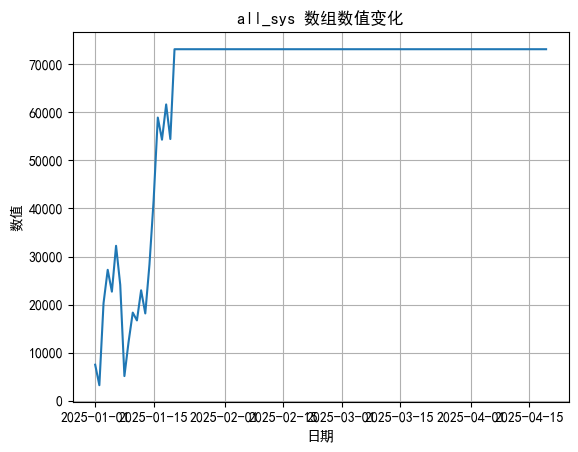

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 all_sys 数组已经定义
# all_sys = [1, 3, 2, 5, 4, 6, 5]
# 生成时间序列
dates = pd.date_range(start='2025-01-01', periods=len(total_sys))

# 绘制折线图
plt.plot(dates, total_sys)

# 添加标题和标签
plt.title('all_sys 数组数值变化')
plt.xlabel('日期')
plt.ylabel('数值')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

In [68]:
total_sys

[7516.778523489931,
 3252.516345715491,
 20303.89063190102,
 27247.7317854522,
 22710.23424538451,
 32241.43629128405,
 24130.04670159956,
 5153.863812175419,
 12272.124892463256,
 18353.656637107604,
 16725.00541260661,
 22987.62095081644,
 18179.172801799337,
 28351.796075698723,
 41744.911565669216,
 58907.00157353951,
 54307.741145259104,
 61636.22269588227,
 54443.57708110666,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821568,
 73117.42272821

In [69]:
max_return_df.tail(15)['sy'].cumsum()

date_key
2025-02-14    0.099357
2025-02-17    0.181495
2025-02-18    0.146373
2025-02-19    0.196630
2025-02-25    0.186101
2025-02-26    0.237596
2025-02-27    0.303586
2025-02-28    0.155135
2025-03-03    0.098532
2025-03-05    0.172340
2025-03-07    0.140832
2025-03-10    0.195125
2025-03-11    0.359369
2025-03-12    0.321106
2025-03-17    0.396274
Name: sy, dtype: float64

In [70]:
max_rate_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_1return,cumulative_1returns,sy,sell_day
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-14,2591,低吸,绿盘低吸,002929.XSHE,润建股份,1,"000012.BKDL,000026.BKDL,000018.BKDL,000019.BKD...","885517.DDBK,885461.DDBK,886062.DDBK,885564.DDB...","980753.ZHBK,980376.ZHBK",1,1,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,206.01,227.51,0.0,-3.57,48.41,55.22,-1.0,53.00,51.65,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,22.01,-20.79,30,-42.30,-1.50,55,2025-02-28 17:23:28,103548990.0,0.094815,0.093815,0.066928,0.065928,51.65,53.00,51.44,50.97,56.58,53.02,62.24,58.81,68.46,68.46,70.95,74.00,64.99,64.11,63.48,64.84,60.99,63.00,56.30,59.50,48.21,0.070354,0.484413,0.099357,1.0
2025-02-17,2626,低吸,绿盘低吸,002031.XSHE,巨轮智能,1,"000038.BKDL,000018.BKDL,000006.BKDL,000034.BKD...","885930.DDBK,885694.DDBK,885502.DDBK,885517.DDB...",980365.ZHBK,2,1,33,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,0.0,1626.24,1522.42,0.0,-9.95,7.60,8.51,-1.0,8.30,8.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,62.08,10.77,20,-1.26,22.70,36,2025-02-28 17:24:26,292162582.0,0.092105,0.091105,0.063158,0.062158,8.08,8.30,8.89,8.01,9.16,9.23,9.23,9.19,9.51,9.14,10.46,9.40,10.50,10.60,10.80,10.30,9.97,10.61,9.90,9.96,7.67,0.052455,0.509822,0.082138,1.0
2025-02-18,2702,低吸,绿盘低吸,002908.XSHE,德生科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000010.BKD...","885975.DDBK,885757.DDBK,886041.DDBK,885629.DDB...","980753.ZHBK,980366.ZHBK,980376.ZHBK",2,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,114.17,261.25,0.0,0.00,10.11,9.62,-1.0,9.89,10.58,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,76.74,-11.68,12,7.28,-12.23,26,2025-02-28 17:25:28,15334848.0,-0.021761,-0.022761,0.046489,0.045489,10.58,9.89,10.48,10.70,10.68,10.25,10.38,10.51,10.14,10.10,10.56,10.22,10.30,10.54,9.63,10.20,9.75,9.70,10.04,9.77,10.25,0.031195,0.525726,0.032195,1.0
2025-02-19,2754,低吸,绿盘低吸,002123.XSHE,梦网科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885757.DDBK,886019.DDBK,886041.DDBK,885816.DDB...","980753.ZHBK,980355.ZHBK,980376.ZHBK",2,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1691.14,1628.36,0.0,-8.16,17.00,19.42,-1.0,18.39,19.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,77.61,-4.09,9,13.85,2.07,24,2025-02-28 17:26:27,422170724.0,0.081765,0.080765,0.119412,0.118412,19.03,18.39,19.08,19.32,17.24,18.48,17.68,16.66,17.81,17.69,17.49,18.00,17.60,17.30,18.15,17.50,18.82,17.75,19.60,18.87,17.51,0.085808,0.570838,0.050257,1.0
2025-02-25,2979,低吸,绿盘低吸,002929.XSHE,润建股份,1,"000012.BKDL,000026.BKDL,000018.BKDL,000019.BKD...","885517.DDBK,885461.DDBK,886062.DDBK,885564.DDB...","980753.ZHBK,980376.ZHBK",1,1,34,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0.0,533.00,465.27,0.0,-9.64,64.11,64.99,-1.0,64.84,63.48,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,52.38,-33.66,21,3.50,-17.58,25,2025-02-28 17:30:34,173491853.0,0.011387,0.010387,-0.009827,-0.010827,63.48,64.84,60.99,63.00,56.30,59.50,57.99,57.50,57.78,55.10,61.52,60.20,62.00,63.72,62.49,60.10,58.62,60.80,62.06,59.02,65.53,-0.032283,0.

In [71]:
max_rate_df.tail(15)['sy'].cumsum()

date_key
2025-02-14    0.099357
2025-02-17    0.181495
2025-02-18    0.213690
2025-02-19    0.263947
2025-02-25    0.194666
2025-02-26    0.246161
2025-02-27    0.312151
2025-02-28    0.163701
2025-03-03    0.172724
2025-03-05    0.208049
2025-03-07    0.124778
2025-03-10    0.179071
2025-03-11    0.343315
2025-03-12    0.345035
2025-03-17    0.360471
Name: sy, dtype: float64

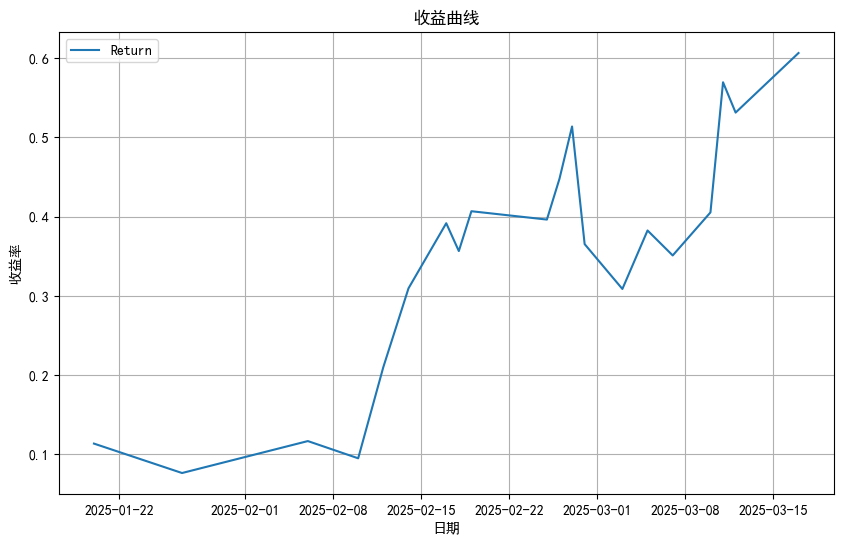

In [72]:
max_return_df['cumulative_returns'] = max_return_df['sy'].cumsum()
plot(max_return_df, 'cumulative_returns')

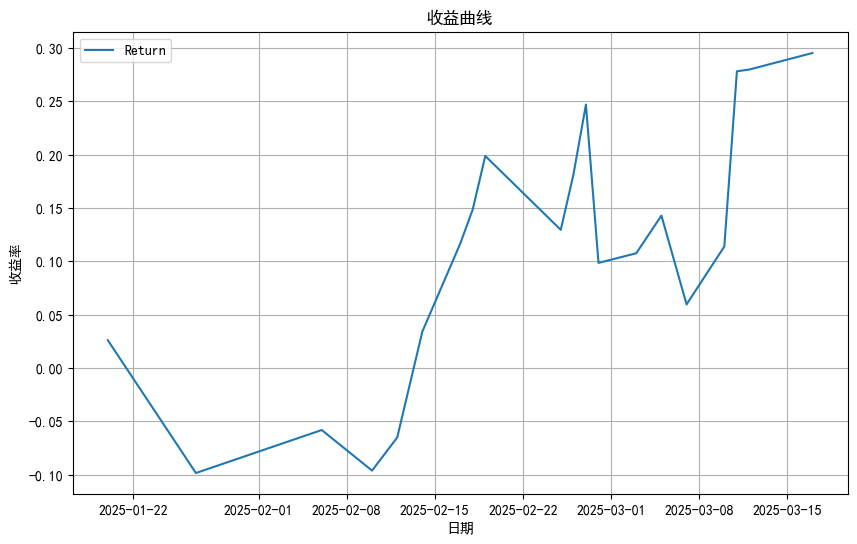

In [73]:
max_rate_df['cumulative_returns'] = max_rate_df['sy'].cumsum()
plot(max_rate_df, 'cumulative_returns')

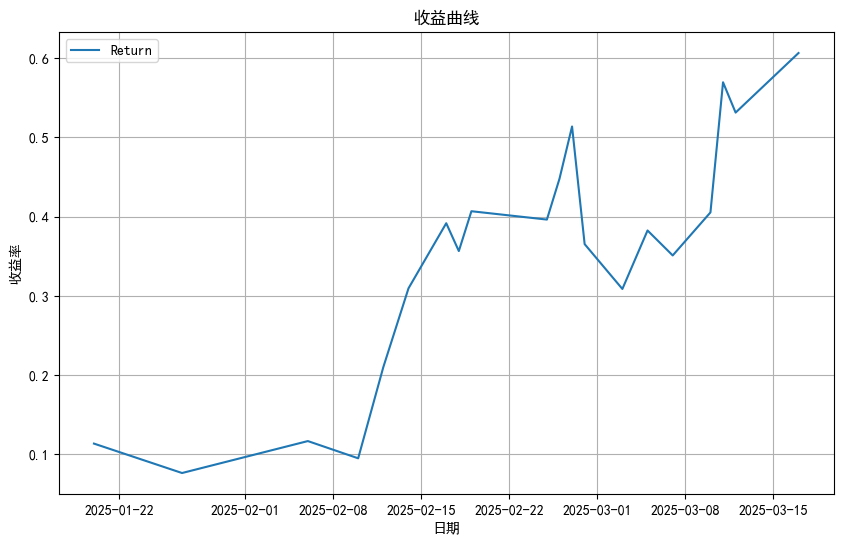

In [74]:
max_ykb_df['cumulative_returns'] = max_ykb_df['sy'].cumsum()
plot(max_ykb_df, 'cumulative_returns')

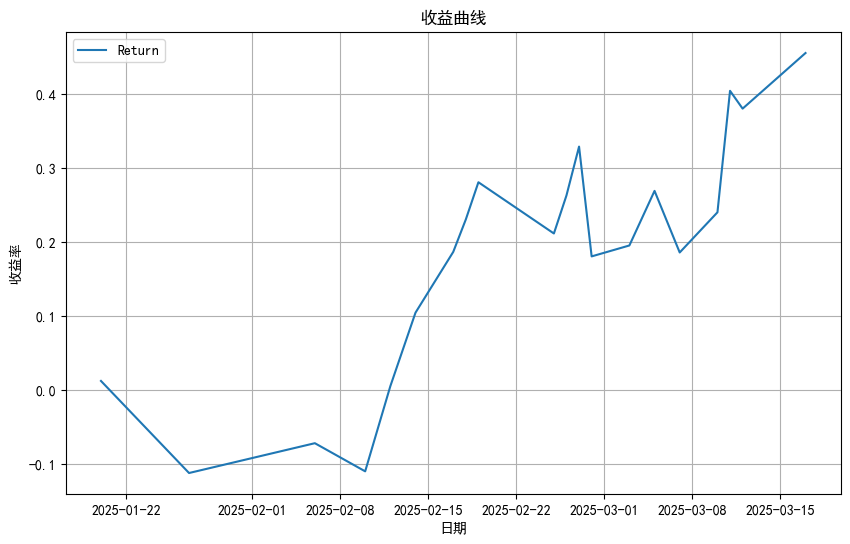

In [75]:
min_hc_df['cumulative_returns'] = min_hc_df['sy'].cumsum()
plot(min_hc_df, 'cumulative_returns')

In [43]:
max_ykb_df.tail(15)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,sy,sell_day,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-14,2591,低吸,绿盘低吸,002929.XSHE,润建股份,1,"000012.BKDL,000026.BKDL,000018.BKDL,000019.BKD...","885517.DDBK,885461.DDBK,886062.DDBK,885564.DDB...","980753.ZHBK,980376.ZHBK",1,1,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,206.01,227.51,0.0,-3.57,48.41,55.22,-1.0,53.00,51.65,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,22.01,-20.79,30,-42.30,-1.50,55,2025-02-28 17:23:28,103548990.0,0.094815,0.093815,0.066928,0.065928,51.65,53.00,51.44,50.97,56.58,53.02,62.24,58.81,68.46,68.46,70.95,74.00,64.99,64.11,63.48,64.84,60.99,63.00,56.30,59.50,48.21,0.071354,1.0,0.071354
2025-02-17,2626,低吸,绿盘低吸,002031.XSHE,巨轮智能,1,"000038.BKDL,000018.BKDL,000006.BKDL,000034.BKD...","885930.DDBK,885694.DDBK,885502.DDBK,885517.DDB...",980365.ZHBK,2,1,33,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,0.0,1626.24,1522.42,0.0,-9.95,7.60,8.51,-1.0,8.30,8.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,62.08,10.77,20,-1.26,22.70,36,2025-02-28 17:24:26,292162582.0,0.092105,0.091105,0.063158,0.062158,8.08,8.30,8.89,8.01,9.16,9.23,9.23,9.19,9.51,9.14,10.46,9.40,10.50,10.60,10.80,10.30,9.97,10.61,9.90,9.96,7.67,0.053455,1.0,0.124810
2025-02-18,2702,低吸,绿盘低吸,002908.XSHE,德生科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000010.BKD...","885975.DDBK,885757.DDBK,886041.DDBK,885629.DDB...","980753.ZHBK,980366.ZHBK,980376.ZHBK",2,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,114.17,261.25,0.0,0.00,10.11,9.62,-1.0,9.89,10.58,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,76.74,-11.68,12,7.28,-12.23,26,2025-02-28 17:25:28,15334848.0,-0.021761,-0.022761,0.046489,0.045489,10.58,9.89,10.48,10.70,10.68,10.25,10.38,10.51,10.14,10.10,10.56,10.22,10.30,10.54,9.63,10.20,9.75,9.70,10.04,9.77,10.25,0.032195,1.0,0.157005
2025-02-19,2754,低吸,绿盘低吸,002123.XSHE,梦网科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885757.DDBK,886019.DDBK,886041.DDBK,885816.DDB...","980753.ZHBK,980355.ZHBK,980376.ZHBK",2,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1691.14,1628.36,0.0,-8.16,17.00,19.42,-1.0,18.39,19.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,77.61,-4.09,9,13.85,2.07,24,2025-02-28 17:26:27,422170724.0,0.081765,0.080765,0.119412,0.118412,19.03,18.39,19.08,19.32,17.24,18.48,17.68,16.66,17.81,17.69,17.49,18.00,17.60,17.30,18.15,17.50,18.82,17.75,19.60,18.87,17.51,0.086808,1.0,0.243812
2025-02-25,2979,低吸,绿盘低吸,002929.XSHE,润建股份,1,"000012.BKDL,000026.BKDL,000018.BKDL,000019.BKD...","885517.DDBK,885461.DDBK,886062.DDBK,885564.DDB...","980753.ZHBK,980376.ZHBK",1,1,34,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0.0,533.00,465.27,0.0,-9.64,64.11,64.99,-1.0,64.84,63.48,-1.0,-1.0,-1.0,-1.0,0,0,9G0002,绿盘低吸,52.38,-33.66,21,3.50,-17.58,25,2025-02-28 17:30:34,173491853.0,0.011387,0.010387,-0.009827,-0.010827,63.48,64.84,60.99,63.00,56.30,59.50,57.99,57.50,57.78,55.10,61.52,60.20,62.00,63.72,62.49,60.10,58.62,60.80,62.06,59.02,65.53,-0.031283,1.0,0.212529
2025-02-26,3068,低吸,绿盘低吸,002522.XSHE,浙

In [44]:
ddwndx['r_1return'] = ddwndx['close_1'] / ddwndx['real_open'] - 1
ddwndx['r_1return'] = ddwndx['r_1return']-0.001
ddwndx['cumulative_1returns'] = (1 + ddwndx['r_1return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_1return', _print=True, save_to_file=True)
print('-----------------------------------------------------')

return:
最大回撤: -79.29%
加和的最大回撤: -144.77%
夏普比率: -0.05
总收益率: -45.20%
年化收益率: -166.89%
波动率: 9.42%
总盈亏: -55.96%
成功次数: 32
失败次数: 33
加和的收益: -31.76%
总天数: 65
总交易次数: 65
交易频率: 100.00%
胜率: 49.23%
平均盈利: 7.15%
平均亏损: -7.90%
最大盈利: 29.90%
最大亏损: -19.19%
盈亏比: 0.91
凯利公式最佳仓位: -6.84%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\1323985323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_1return'] = ddwndx['close_1'] / ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\1323985323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_1return'] = ddwndx['r_1return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_42648\1323985323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [45]:
ddwndx2 = ddwndx.copy()
ddwndx2 = ddwndx2[ddwndx2['close_2'] > 0]
ddwndx2['r_2return'] = ddwndx2['close_2'] / ddwndx2['real_open'] - 1
ddwndx2['r_2return'] = ddwndx2['r_2return']-0.001

ddwndx2['cumulative_2returns'] = (1 + ddwndx2['r_2return']).cumprod()
print("return:")
caculate_returns_n(ddwndx2, 'r_2return', _print=True)
print('-----------------------------------------------------')

return:


NameError: name 'caculate_returns_n' is not defined

In [ ]:
def caculate_returns_n(returns_df, row, n=1000, _print=False):
    r = {}
    # 计算每天的收益金额
    daily_profit = n * returns_df[row]
    # 计算累计收益金额
    cumulative_profit = daily_profit.cumsum()

    # 计算最大回撤
    cumulative_max = cumulative_profit.cummax()
    drawdown = (cumulative_profit - cumulative_max)
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (daily_profit.mean() - risk_free_rate) / daily_profit.std()

    # 计算总收益率
    total_return = cumulative_profit.iloc[-1] / n

    # 计算波动率
    volatility = daily_profit.std()

    # 计算总盈亏
    total_profit_loss = cumulative_profit.iloc[-1]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = daily_profit[daily_profit > 0].count()
    losing_trades = daily_profit[daily_profit < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = daily_profit[daily_profit > 0].mean() if profitable_trades > 0 else 0
    average_loss = daily_profit[daily_profit < 0].mean() if losing_trades > 0 else 0
    max_profit = daily_profit.max()
    max_loss = daily_profit.min()
    total_trades = profitable_trades + losing_trades
    total_times = daily_profit.count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] = max_drawdown / n
    r['夏普比率'] = sharpe_ratio
    r['总收益率'] = total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown / n:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2f}")
        print(f"总盈亏: {total_profit_loss:.2f}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2f}")
        print(f"平均亏损: {average_loss:.2f}")
        print(f"最大盈利: {max_profit:.2f}")
        print(f"最大亏损: {max_loss:.2f}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:
i=3
ddwndx_i = ddwndx.copy()
# 筛选出 close_i 大于 0 的数据
ddwndx_i = ddwndx_i[ddwndx_i[f'close_{i}'] > 0]
# 计算 r_ireturn
ddwndx_i[f'r_{i}return'] = ddwndx_i[f'close_{i}'] / ddwndx_i['real_open'] - 1
# 扣除手续费
ddwndx_i[f'r_{i}return'] = ddwndx_i[f'r_{i}return'] - 0.001

print(len(ddwndx_i[ddwndx_i[f'r_{i}return'] > 0]))
# 计算累计收益
ddwndx_i[f'cumulative_{i}returns'] = (1 + ddwndx_i[f'r_{i}return']).cumprod()
print(f"return_{i}:")
caculate_returns_n(ddwndx_i, f'r_{i}return', _print=True)
print('-----------------------------------------------------')

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

In [ ]:
ddwndx.tail(20)

In [ ]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

In [ ]:
plot(ddwndx, 'cumulative_returns')

In [ ]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

In [ ]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

In [ ]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [ ]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [ ]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [ ]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%
